# Read in the data

## Goal

We aim here at investing demographic fairness in the **SAT Exams** in New York City in consideration for admission into college.

In [153]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

#Files required for analysis
data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

#dictionary to hold all the datasets
data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [121]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

C:\Users\TANYU\AppData\Local\Temp\ipykernel_1792\3674931809.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  survey["DBN"] = survey["dbn"]


# Add DBN columns

In [122]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [123]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [124]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [125]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [126]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

C:\Users\TANYU\AppData\Local\Temp\ipykernel_1792\3398560250.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  combined = combined.fillna(combined.mean())


# Add a school district column for mapping

In [127]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [128]:
correlations = combined.corr()

# Plotting survey correlations

In [129]:
""" 
Remove DBN since it's a unique identifier, not a useful numerical
value for correlation. The cell to do this is run once.

"""
survey_fields.remove("DBN")


In [130]:
combined_survey = combined.loc[:,survey_fields]

In [131]:
correlations_survey = correlations.loc[survey_fields,"sat_score"]
correlations_survey

rr_s          0.232199
rr_t         -0.023386
rr_p          0.047925
N_s           0.423463
N_t           0.291463
N_p           0.421530
saf_p_11      0.122913
com_p_11     -0.115073
eng_p_11      0.020254
aca_p_11      0.035155
saf_t_11      0.313810
com_t_11      0.082419
eng_t_11      0.036906
aca_t_11      0.132348
saf_s_11      0.337639
com_s_11      0.187370
eng_s_11      0.213822
aca_s_11      0.339435
saf_tot_11    0.318753
com_tot_11    0.077310
eng_tot_11    0.100102
aca_tot_11    0.190966
Name: sat_score, dtype: float64

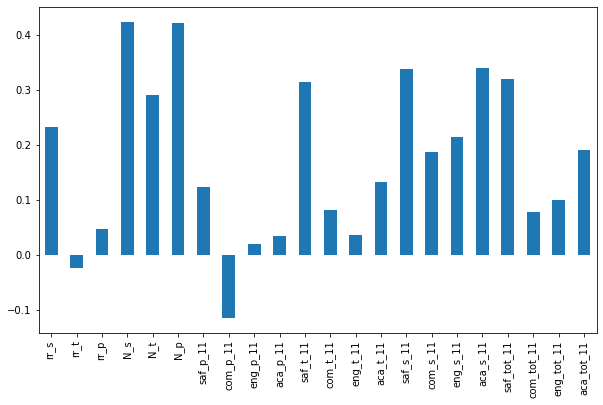

In [132]:
correlations_survey.plot.bar(figsize = (10,6));
plt.show();

There are high correlations between `N_s`, `N_t`, `N_p`, and `sat_score`. Since these columns are correlated with `total_enrollment`, it makes sense that they would be high.

It is more interesting that `rr_s`, the student response rate, or the percentage of students that completed the survey, correlates with `sat_score` This might make sense because students who are more likely to fill out surveys may be more likely to also be doing well academically.

How students and teachers percieved safety (`saf_t_11` and `saf_s_11`) correlate with `sat_score`. This make sense — it's difficult to teach or learn in an unsafe environment.

The last interesting correlation is the `aca_s_11`, which indicates how the student perceives academic standards, correlates with `sat_score`, but this is not true for `aca_t_11`, how teachers perceive academic standards, or `aca_p_11`, how parents perceive academic standards.


# Safety and SAT Scores

As already mentioned above, safety as percieved by parents and safety as perceived by students correlates strongly with the `sat Score`. We will now delve deeper into finding which schools have low safety measures.

In [133]:
## Selecting column names that involves safety.
safety_fields = [col for col in combined_survey.columns if 'saf' in col]

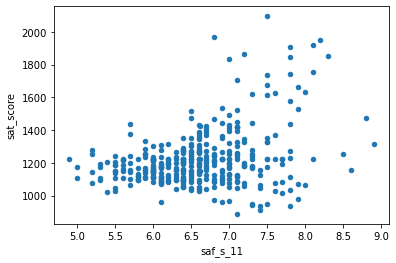

In [134]:
combined.plot.scatter(x = "saf_s_11", y = "sat_score")
plt.show();

Though not very strong, there exist a correlation between student's safety perception and `Sat Score`. There are some school with very high `sat scores` and high safety score.

In [167]:
safety_by_borough = combined.groupby('boro').agg(np.mean)['saf_s_11']

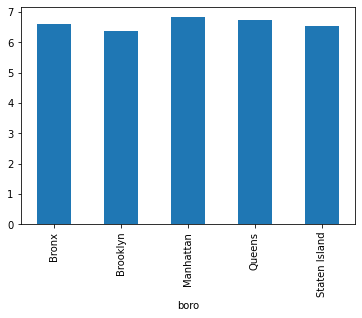

In [168]:
safety_by_borough.plot.bar();

It shows that the student safety scores are generally high in all boroughs but  are more higher in **Manhattana** and **Queens**

# Race and SAT Score

Now, it is time for us to see how racial differences reflects SAT scores.

In [177]:
#Isolate columns names relating to race.
race = ["white_per","asian_per", "black_per","hispanic_per"]

In [174]:
racial_correlation = correlations['sat_score'][race]
racial_correlation

white_per       0.620718
asian_per       0.570730
black_per      -0.284139
hispanic_per   -0.396985
Name: sat_score, dtype: float64

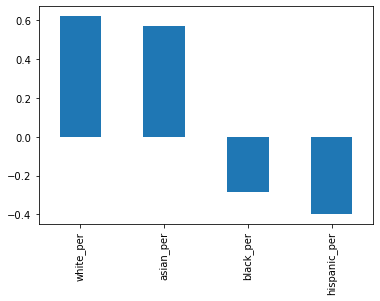

In [176]:
racial_correlation.plot.bar();

It looks like a higher percentage of white or Asian students at a school correlates positively with SAT scores, whereas a higher percentage of black or Hispanic students correlates negatively with SAT score. This may be due to a lack of funding for schools in certain areas, which are more likely to have a higher percentage of black or Hispanic students.

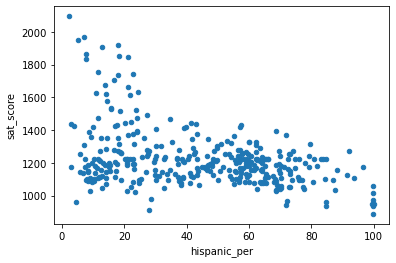

In [179]:
combined.plot.scatter(x = "hispanic_per", y = "sat_score");

It is further seen here that `sat_score` decreases with an increase in percentage of a hispanic students in a given school.

In [192]:
combined[combined['hispanic_per'] > 95]['school_name']

44                         Manhattan Bridges High School
82      Washington Heights Expeditionary Learning School
89     Gregorio Luperon High School for Science and M...
125                  Academy for Language and Technology
141                International School for Liberal Arts
176     Pan American International High School at Monroe
253                            Multicultural High School
286               Pan American International High School
Name: school_name, dtype: object

The schools listed above appear to primarily serve recent immigrants to the U.S. These schools have many students who are learning English, which would explain the lower SAT scores.

In [200]:
combined[(combined['hispanic_per'] < 10)&(combined['sat_score'] > 1800)]['school_name']

37                                Stuyvesant High School
151                         Bronx High School of Science
187                       Brooklyn Technical High School
327    Queens High School for the Sciences at York Co...
356                  Staten Island Technical High School
Name: school_name, dtype: object

Many of the schools above appear to be specialized science and technology schools that receive extra funding and only admit students who pass an entrance exam. This doesn't explain the low hispanic_per, but it does explain why their students tend to do better on the SAT — they are students from all over New York City who did well on a standardized test.


# Gender and SAT score

In [201]:
gender = ["male_per","female_per"]

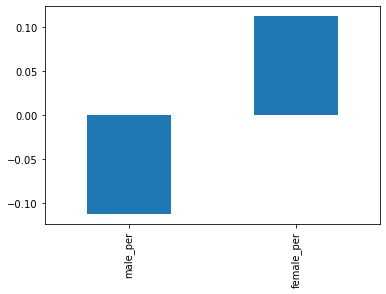

In [205]:
correlations.loc[gender,"sat_score"].plot.bar();

In the plot above, we can see that a high percentage of females at a school positively correlates with SAT scores, whereas a high percentage of males at a school negatively correlates with SAT scores. Neither correlation is extremely strong.

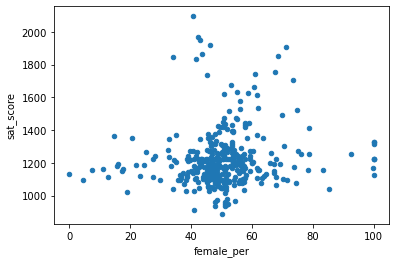

In [207]:
combined.plot.scatter(x = "female_per", y = "sat_score");

No significant correlation recorded between female percentage and the scholastic aptitute test scores, however, we notice a cluster of schools with high percentage of females (`60` to `80`) and high SAT scores.

In [208]:
combined[(combined["female_per"] > 60) & (combined["sat_score"] > 1700)]["school_name"]

5                         Bard High School Early College
26                         Eleanor Roosevelt High School
60                                    Beacon High School
61     Fiorello H. LaGuardia High School of Music & A...
302                          Townsend Harris High School
Name: school_name, dtype: object

These schools appear to be very selective liberal arts schools that have high academic standards.